In [5]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
def extract_metric(report_path, metric_name):
    with open(report_path, 'r') as file:
        content = file.read()
        # Adjusted regex pattern to be more flexible with spaces and optional percentage sign
        match = re.search(rf'{re.escape(metric_name)}\s*\[?\%?\]?\s*([\d.]+)', content)
        if match:
            return float(match.group(1))
        else:
            return None

def collect_agent_metrics(base_dir, agent_name):
    metrics = {
        'Collision Rate': [],
        'Success Rate': [],
        'Progression': [],
        'Avg. Number of Timesteps': [],
        'Avg. Speed [m/s]': [],
        'Avg. Absolute Path Error [m]': []
    }
    scenarios = []
    episode_metrics = {
        'Collision': [],
        'Success': [],
        'Progression': [],
        'Timesteps': [],
        # 'Speed': [], #TODO uncomment when speed is added to the csv
        'Avg Absolute Path Error': []
    }

    for test_scen in os.listdir(base_dir):
        test_scen_dir = os.path.join(base_dir, test_scen)
        if os.path.isdir(test_scen_dir):
            agent_dir_path = os.path.join(test_scen_dir, agent_name)
            report_path = os.path.join(agent_dir_path, 'report.txt')
            csv_path = os.path.join(agent_dir_path, 'test_summary.csv')
            if os.path.exists(report_path):
                for metric_name in metrics.keys():
                    metric_value = extract_metric(report_path, metric_name)
                    if metric_value is not None:
                        metrics[metric_name].append(metric_value)
                scenarios.append(test_scen)
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                for metric_name in episode_metrics.keys():
                    episode_metrics[metric_name].append(df[metric_name].values)

    return metrics, episode_metrics, scenarios

def calculate_confidence_intervals(episode_metrics): #TODO verify this code
    confidence_intervals = {}
    for metric_name, values in episode_metrics.items():
        means = [np.mean(v) for v in values]
        sems = [np.std(v)/np.sqrt(len(v)) for v in values]
        cis = [1.96 * sem for sem in sems]
        confidence_intervals[metric_name] = (means, cis)
    return confidence_intervals

plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
base_color = '#FF7F50'


def visualize_metrics(metrics, scenarios, metric_name, ylabel, show_ci=False, episode_metrics=None):
    values = metrics[metric_name]
    if show_ci:
        means, cis = calculate_confidence_intervals(episode_metrics)[metric_name]

    fig, ax = plt.subplots(figsize=(10, 6))
    if show_ci:
        ax.bar(scenarios, means, yerr=cis, color=base_color, edgecolor='black', linewidth=1.5, capsize=5)
    else:
        ax.bar(scenarios, values, color=base_color, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# def visualize_percentages_together_one_agent(metrics, scenarios): #Somewhat outdated
#     metric_names = ['Success Rate', 'Collision Rate', 'Progression']
#     colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
#     percentage_metrics = {name: metrics[name] for name in metric_names}

#     x = np.arange(len(scenarios))
#     width = 0.2

#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     for i, (metric_name, values) in enumerate(percentage_metrics.items()):
#         ax.bar(x + width*i, values, width, label=metric_name, color=colors[i])

#     ax.set_xlabel('Scenarios')
#     ax.set_ylabel('Percentage')
#     ax.set_xticks(x + width)
#     ax.set_xticklabels(scenarios, rotation=45, ha='right')
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

def visualize_two_agents(metrics1, metrics2, scenarios, metric_name, ylabel, show_ci=False, episode_metrics1 =None, episode_metrics2=None, label1='Agent 1', label2='Agent 2'):
    values1 = metrics1[metric_name]
    values2 = metrics2[metric_name]
    if show_ci:
        means1, cis1 = calculate_confidence_intervals(episode_metrics1)[metric_name]
        means2, cis2 = calculate_confidence_intervals(episode_metrics2)[metric_name]

    x = np.arange(len(scenarios))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    if show_ci:
        ax.bar(x - width/2, means1, width, yerr=cis1, label=label1, color=base_color, edgecolor='black', linewidth=1.5, capsize=5)
        ax.bar(x + width/2, means2, width, yerr=cis2, label=label2, color='#F6DEB8', edgecolor='black', linewidth=1.5, capsize=5)
    else:
        ax.bar(x - width/2, values1, width, label=label1, color=base_color, edgecolor='black', linewidth=1.5)
        ax.bar(x + width/2, values2, width, label=label2, color='#F6DEB8', edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def visualize_stacked_SR_CR(metrics1, scenarios, metrics2=None, agent_name1='Agent 1', agent_name2='Agent 2'):
    x = np.arange(len(scenarios))
    width = 0.35
    colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
    colors = ['#008B8B', 'magenta', '#89CFF0'] # Dark cyan, magenta, baby blue
    colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan pink blue
    colors = ['#F6DEB8', '#A23C9D', '#FF7F50'] # tan darkmagenta coral
    fig, ax = plt.subplots(figsize=(12, 8))

    if metrics2 is None:
        success_rates = metrics1['Success Rate']
        collision_rates = metrics1['Collision Rate']

        ax.bar(x, collision_rates, width, label='Collision Rate', color=colors[2],edgecolor='black', linewidth=1.5)
        ax.bar(x, success_rates, width, bottom=collision_rates, label='Success Rate', color=colors[0],edgecolor='black', linewidth=1.5)

    else:
        success_rates1 = metrics1['Success Rate']
        success_rates2 = metrics2['Success Rate']
        collision_rates1 = metrics1['Collision Rate']
        collision_rates2 = metrics2['Collision Rate']

        ax.bar(x - width/2, success_rates1, width, bottom=collision_rates1, label=f'Success Rate {agent_name1}', color=colors[2],edgecolor='black', linewidth=1.5)#, hatch='//')
        ax.bar(x + width/2, success_rates2, width, bottom=collision_rates2, label=f'Success Rate {agent_name2}', color=colors[0],edgecolor='black', linewidth=1.5)#, hatch='o')
        
        ax.bar(x - width/2, collision_rates1, width, label=f'Collision Rate {agent_name1}', color=colors[2], hatch='xx',edgecolor='black', linewidth=1.5)
        ax.bar(x + width/2, collision_rates2, width, label=f'Collision Rate {agent_name2}', color=colors[0], hatch='xxx',edgecolor='black', linewidth=1.5)


    ax.set_xlabel('Scenarios')
    ax.set_ylabel('Percentage')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

### Available metrics:
```'Collision Rate'```

```'Success Rate'```

```'Progression'```

```'Avg. Number of Timesteps'```

```'Avg. Speed [m/s]'```

```'Avg. Absolute Path Error [m]'```

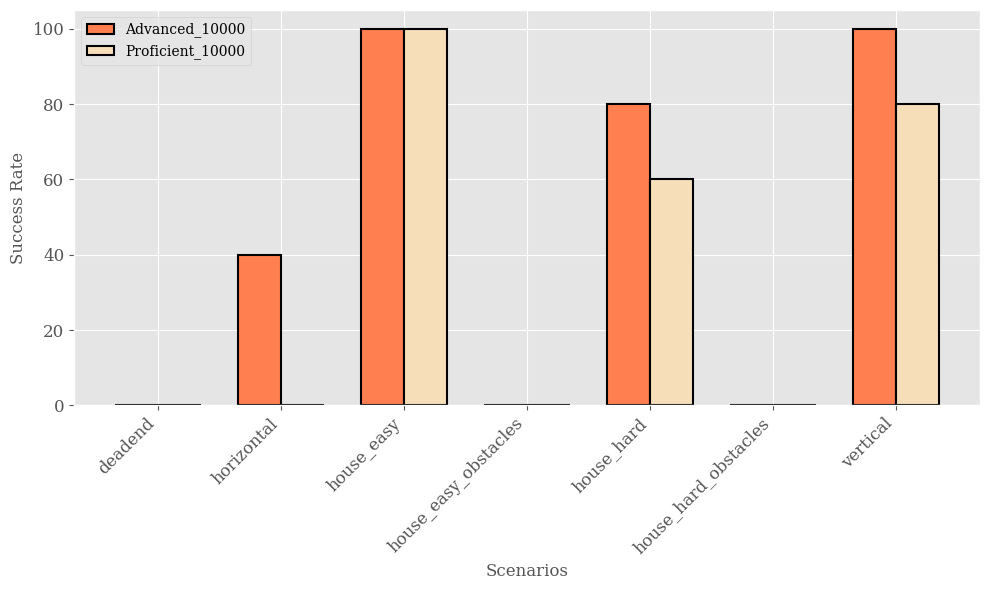

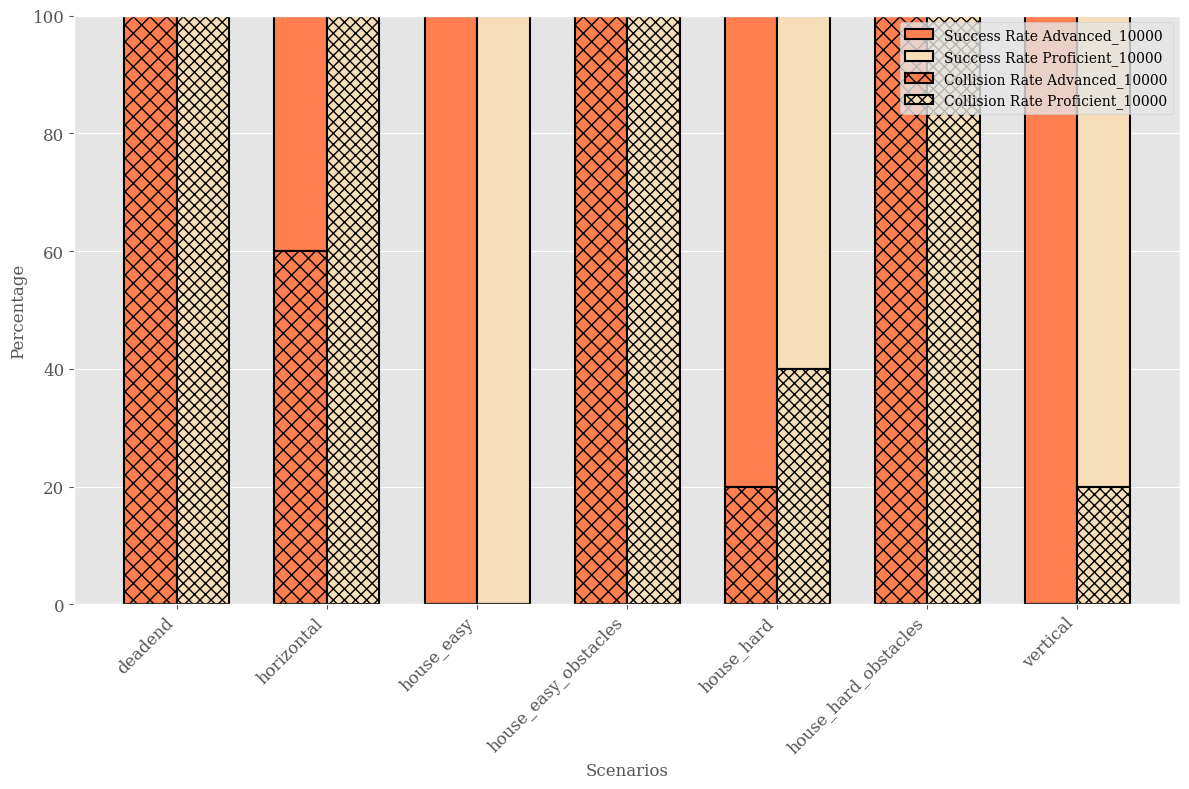

In [7]:
exp_id = 32
trained_scen = "advanced"
agent_name = "test_agent_model_10000" 
exp_dir_path = f'Experiment {exp_id}'
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

metrics1,ep_met1, scenarios1 = collect_agent_metrics(base_dir, agent_name)

trained_scen = "proficient"
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

metrics2,ep_met2, scenarios2 = collect_agent_metrics(base_dir, agent_name)

assert scenarios1 == scenarios2 

# For comparing two agents
visualize_two_agents(metrics1, metrics2, scenarios1, 'Success Rate', 'Success Rate',label1='Advanced_10000', label2='Proficient_10000')

visualize_stacked_SR_CR(metrics1, scenarios2, metrics2, 'Advanced_10000', 'Proficient_10000')


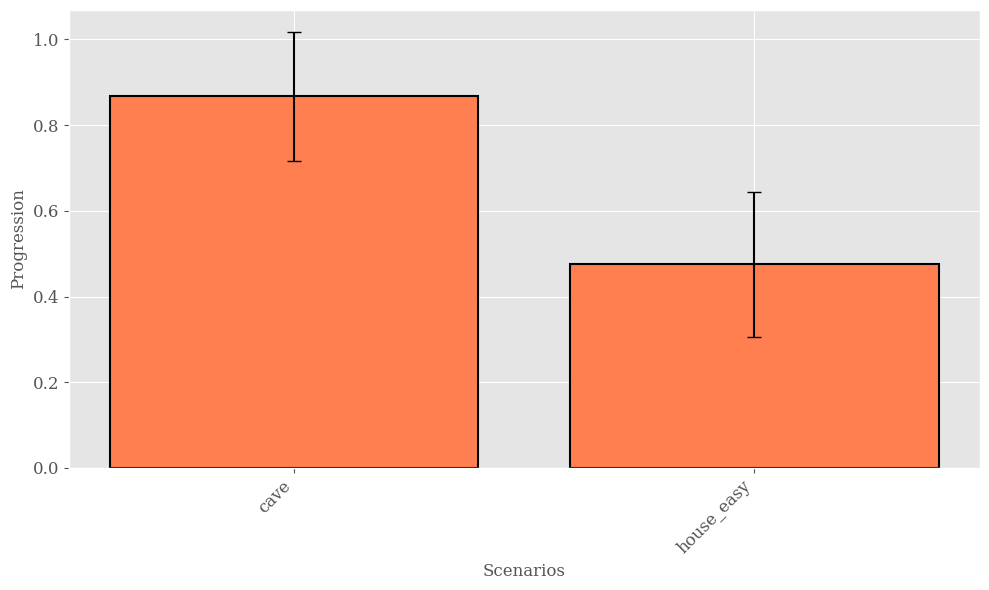

In [8]:
exp_id = 33
trained_scen = "proficient"
agent_name = "test_agent_last_model" 
exp_dir_path = f'Experiment {exp_id}'
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'
metrics, epmet, scenarios = collect_agent_metrics(base_dir, agent_name)

visualize_metrics(metrics, scenarios, 'Progression', 'Progression', show_ci=True, episode_metrics=epmet)
# visualize_metrics(metrics, scenarios, 'Avg. Speed [m/s]', 'Average Speed [m/s]', show_ci=True, episode_metrics=epmet)
# visualize_metrics(metrics, scenarios, 'Avg. Absolute Path Error [m]', 'Average Absolute Path Error [m]', show_ci=True, episode_metrics=epmet)

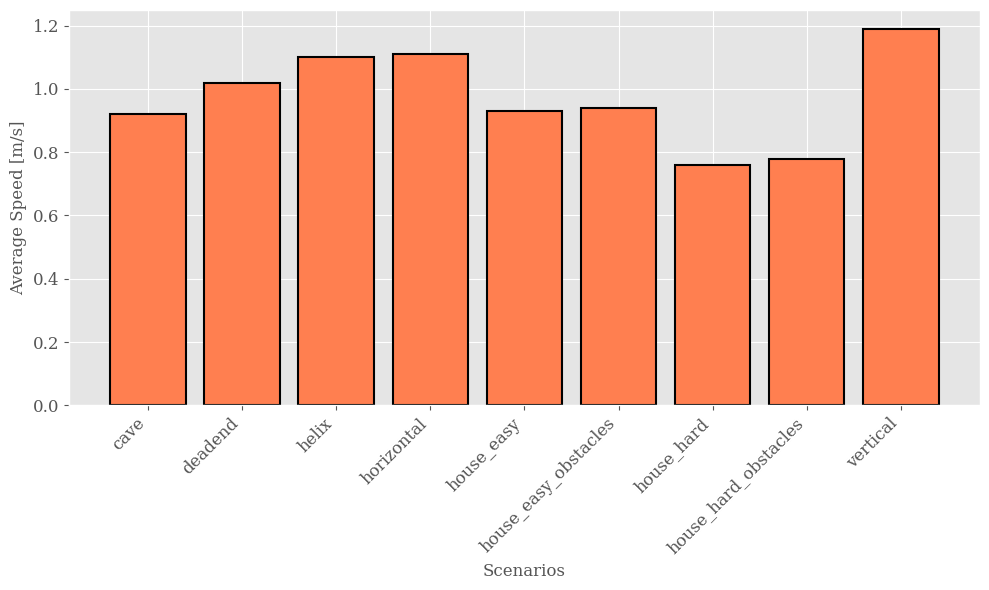

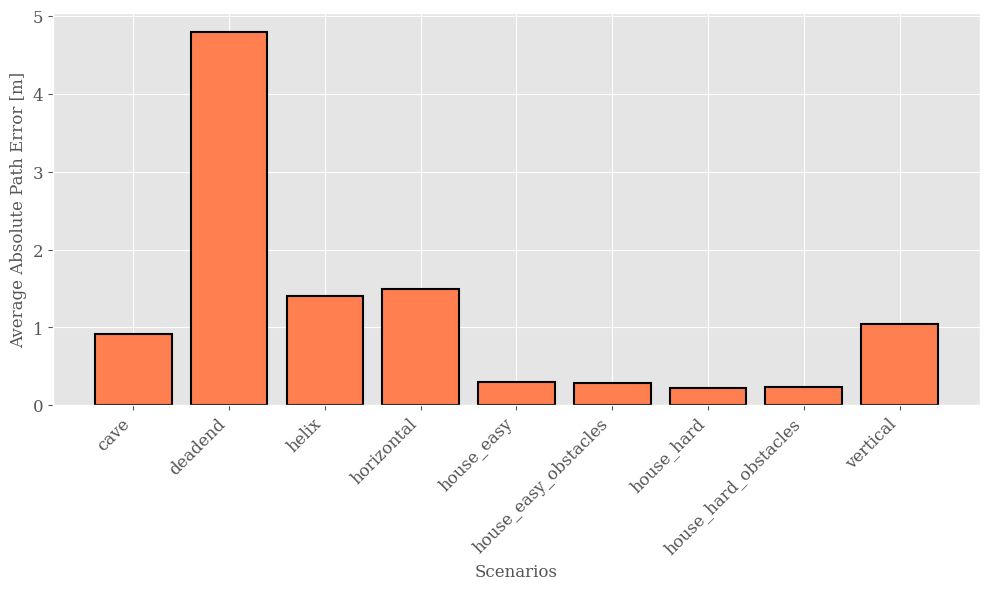

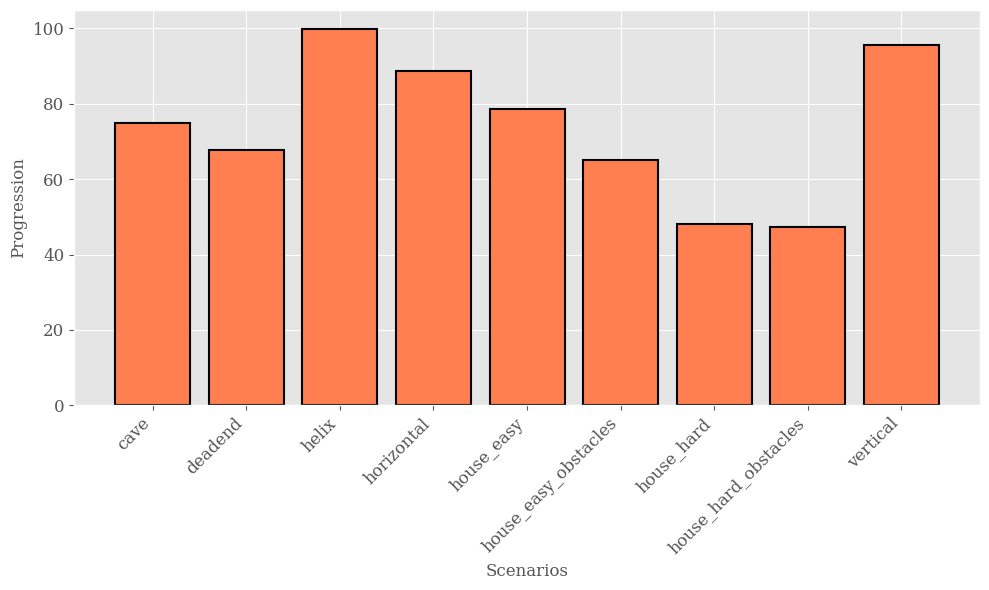

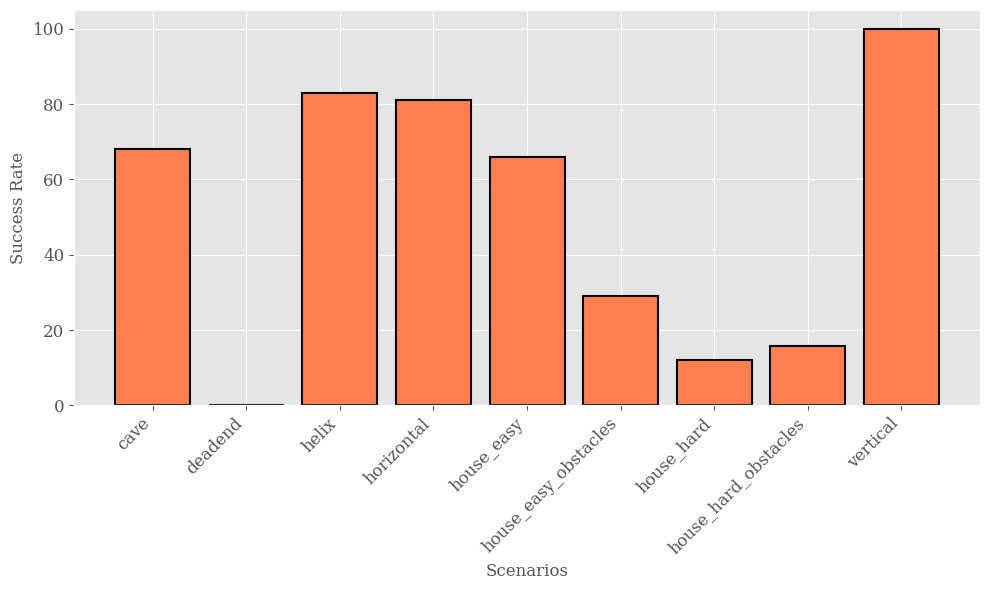

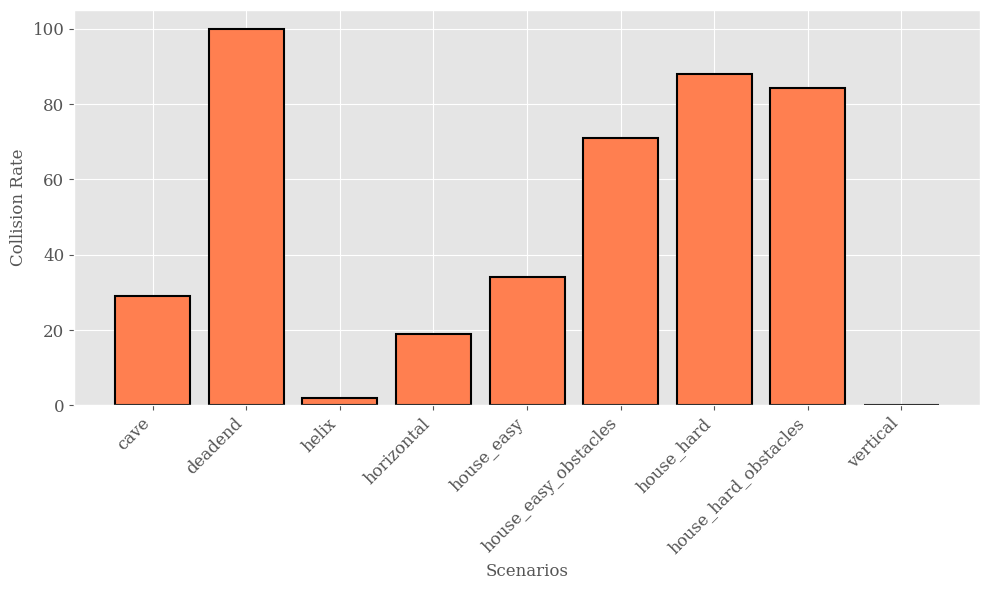

In [12]:
exp_id = 32
trained_scen = "advanced"
agent_name = "test_agent_model_10000" 
exp_dir_path = f'Best_agent_res_gen_2 exp {exp_id}'
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

metrics, epmet, scenarios = collect_agent_metrics(base_dir, agent_name)

# For single metric visualization

#Add CI to these
visualize_metrics(metrics, scenarios, 'Avg. Speed [m/s]', 'Average Speed [m/s]')
visualize_metrics(metrics, scenarios, 'Avg. Absolute Path Error [m]', 'Average Absolute Path Error [m]')
visualize_metrics(metrics, scenarios, 'Progression', 'Progression')

#Percentages dont need CI
visualize_metrics(metrics, scenarios, 'Success Rate', 'Success Rate')
visualize_metrics(metrics, scenarios, 'Collision Rate', 'Collision Rate')
# visualize_metrics(metrics, scenarios, 'Avg. Number of Timesteps', 'Average Number of Timesteps') #Unused

# For combined percentage metrics visualization
# visualize_percentages_together_one_agent(metrics, scenarios)